In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.xception import Xception
from keras.models import Sequential
from tensorflow import keras
import json

In [2]:
!gdown "1tN2ZKAkanNjyBAOzz7m-GymQ3GBvRU7k&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1tN2ZKAkanNjyBAOzz7m-GymQ3GBvRU7k&confirm=t
To: /content/archive.zip
100% 688M/688M [00:08<00:00, 77.6MB/s]


In [3]:
!unzip "/content/archive.zip"

串流輸出內容已截斷至最後 5000 行。
  inflating: animals/animals/bison/73b10839bc.jpg  
  inflating: animals/animals/bison/74dc1dd32a.jpg  
  inflating: animals/animals/bison/75ab166a7d.jpg  
  inflating: animals/animals/bison/79e1610d01.jpg  
  inflating: animals/animals/bison/7ba5eee91f.jpg  
  inflating: animals/animals/bison/7d214aab4b.jpg  
  inflating: animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animals/animals/bison/82ec723a4f.jpg  
  inflating: animals/animals/bison/85e145af6c.jpg  
  inflating: animals/animals/bison/862e2c6379.jpg  
  inflating: animals/animals/bison/87a5c700ad.jpg  
  inflating: animals/animals/bison/88b723ce90.jpg  
  inflating: animals/animals/bison/8c3af742c3.jpg  
  inflating: animals/animals/bison/8e34044b98.jpg  
  inflating: animals/animals/bison/8e6adbdc40.jpg  
  inflating: animals/animals/bison/8fce80d5ba.jpg  
  inflating: animals/animals/bison/961a895686.jpg  
  inflating: animals/animals/bison/984a5b583d.jpg  
  inflating: animals/animals/bison/9e150d02

In [4]:
IMAGE_SIZE = (150, 150)

In [5]:
def load_data():

  dataset = '/content/animals/animals'
  output = []
 
  train_images = []
  train_labels = []
  test_images = []
  test_labels = []
  print("Loading {}".format(dataset))
  
  for folder in os.listdir(dataset):
    images = []
    labels = []
    label = folder    
    for file in tqdm(os.listdir(os.path.join(dataset, folder))):

      img_path = os.path.join(os.path.join(dataset, folder), file)
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, IMAGE_SIZE) 
      image = image / 255.0
      
      images.append(image)
      labels.append(label)
    train_images.append(images[:48])
    train_labels.append(labels[:48])
    test_images.append(images[48:])
    test_labels.append(labels[48:])
                
  train_images = np.array(train_images, dtype = 'float32')  
  train_labels = np.array(train_labels, dtype = 'object')
  test_images = np.array(test_images, dtype = 'float32')
  test_labels = np.array(test_labels, dtype = 'object')

  return train_images, train_labels, test_images, test_labels

In [6]:
train_image, train_label, test_image, test_label = load_data()

Loading /content/animals/animals


100%|██████████| 60/60 [00:00<00:00, 111.13it/s]


In [7]:
train_images = []
train_labels = []
test_images = []
test_labels = []
for i in range(90):
  for j in range(48):
    train_images.append(train_image[i][j])
    train_labels.append(train_label[i][j])

for i in range(90):
  for j in range(12):    
    test_images.append(test_image[i][j])
    test_labels.append(test_label[i][j])

train_images = np.array(train_images, dtype = 'float32')  
train_labels = np.array(train_labels, dtype = 'object')
test_images = np.array(test_images, dtype = 'float32')  
test_labels = np.array(test_labels, dtype = 'object')

In [8]:
classnames = list(set(train_labels))

In [9]:
class_names_label = {}
for i, class_name in enumerate(classnames):
  class_names_label[class_name] = i

In [10]:
with open('animal_dict.json', 'w') as f:
    json.dump(class_names_label, f)

In [11]:
n_classes = len(classnames)

In [12]:
for i in range(len(train_labels)):
  train_labels[i] = class_names_label[train_labels[i]]

In [13]:
for i in range(len(test_labels)):
  test_labels[i] = class_names_label[test_labels[i]]

In [14]:
train_labels = np.array(train_labels, dtype = 'int32')
test_labels = np.array(test_labels, dtype = 'int32')

In [15]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [16]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 4320
Number of testing examples: 1080
Each image is of size: (150, 150)


In [17]:
xception_model = Sequential()

xception_base_model = Xception(include_top = False, weights = "imagenet", input_shape = (150, 150, 3))
print(f'Number of layers in Xception : {len(xception_base_model.layers)}')

for layer in xception_base_model.layers[:]:
    layer.trainable = False
    
for layer in xception_base_model.layers[90:]:
    layer.trainable = True

xception_model.add(xception_base_model)

xception_model.add(GlobalAveragePooling2D())

xception_model.add(Dense(units = 90, activation = 'softmax'))

xception_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
xception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
xception = xception_model.fit(train_images, train_labels, batch_size = 64, epochs = 10, callbacks = [early_stopping], validation_split = 0.2)

83683744/83683744 [==============================] - 3s 0us/step
Number of layers in Xception : 132
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 90)                184410    
                                                                 
Total params: 21,045,890
Trainable params: 11,276,730
Non-trainable params: 9,769,160
_________________________________________________________________
Epoch 1/10
54/54 [==============================] - 28s 257ms/step - loss: 3.4995 - accuracy: 0.3675 - val_loss: 1.8168 - val_accuracy

In [18]:
xception_predictions = xception_model.predict(test_images)
xception_predictions = np.argmax(xception_predictions,axis = 1)

34/34 [==============================] - 3s 77ms/step


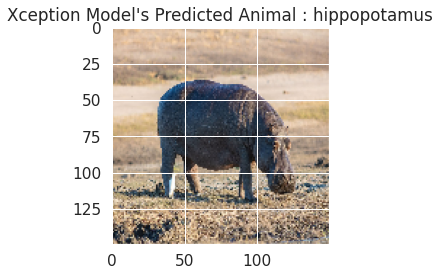

In [19]:
n = np.random.randint(0,np.shape(test_images)[0])

plt.imshow(test_images[n])
plt.title("Xception Model's Predicted Animal : " + str(list(class_names_label.keys())[list(class_names_label.values()).index(xception_predictions[n])]))
plt.show()

In [20]:
xception_model.save('my_model.h5') 